---
title: "Startup COVID time"
author: "Babak Fi Foo"
toc: true
number-sections: true
execute:
  cache: true
---

In [6]:
import sys
sys.path.append('../src/')

import loader

import numpy as np
import pandas as pd
from datetime import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from arch.unitroot.unitroot import DFGLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

plt.rcParams['font.family'] = 'Roboto'

import warnings
warnings.filterwarnings("ignore")

macro_data = loader.startupMacro()
data = macro_data.load()

# Testing for unit root

before performing any time-series analysis, we need to investigate the properties of the series. 
We start by testing whether the two series are stationary. 

The duration that we are interested is quite close to the COVID time where there is an increase in the count of applications for the startup grants. Investigating this period has the potential to wrongly identify the series as a trend stationary.
Therefore ,the whole duration of the data is used for this test statistics to avoid any potential bias.

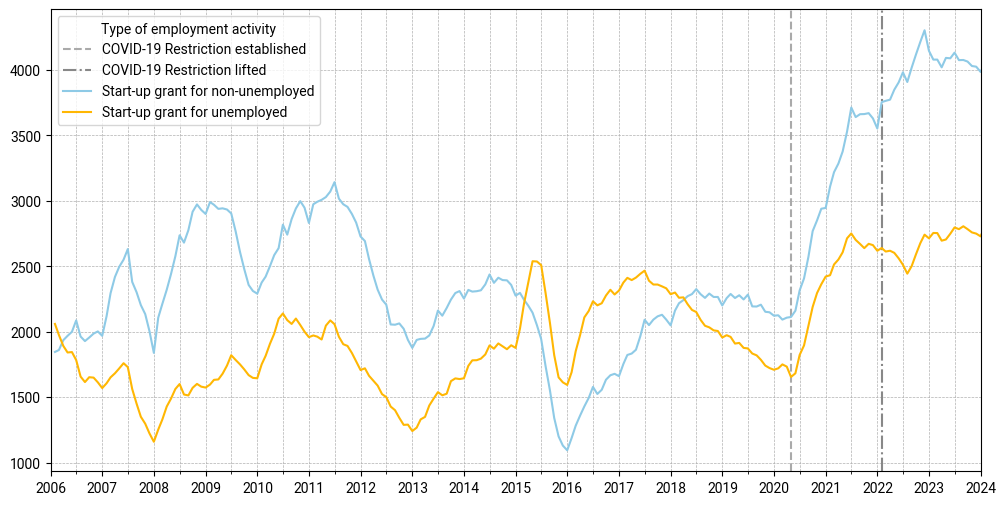

In [7]:
plt.figure(figsize=(12, 6))
plt.grid(True, which="both", ls="--", lw=0.5)

COVID = dt.strptime("2020-05-01", '%Y-%m-%d')
NORMAL = dt.strptime("2022-02-01", '%Y-%m-%d')

ax = plt.gca()


plt.xlim(
	dt.strptime("2006-01-01", '%Y-%m-%d'), 
	dt.strptime("2024-01-01", '%Y-%m-%d')
	)

plt.axvline(x=COVID, color='#AAAAAA', linestyle='--',  label='COVID-19 Restriction established', lw=1.5)
plt.axvline(x=NORMAL, color='#888888', linestyle='-.',  label='COVID-19 Restriction lifted', lw=1.5)
sns.lineplot(data=data.loc[:,[
	"Start-up grant for non-unemployed",
	"Start-up grant for unemployed"
]], palette=["#8ecae6","#ffb703"], dashes=False, ax=ax)
ax.set_xlabel('')

plt.show()

The DF-GLS test for unit-root indicates that both series are affected by unit-root at their 7th lag, and cannot reject the existance of the unit-root. Hence proper alteration should be applied to make the series stationary. 

In [8]:
def gen_dfgls_dict(series, col):
	dfgls = DFGLS(series, max_lags=12, method="bic").summary()
	dfgls = {k:v for k,v in dfgls.tables[0].data}
	dfgls["variables"] = col
	return dfgls

col1 = "Start-up grant for non-unemployed"
col2 = "Start-up grant for unemployed"
print(pd.DataFrame([
    gen_dfgls_dict(data[col1], col1),
    gen_dfgls_dict(data[col2], col2)
    ]).set_index("variables")
)
print("""
Trend: Constant
Critical Values: -2.66 (1%), -2.04 (5%), -1.72 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
"""
)

                                  Test Statistic P-value Lags
variables                                                    
Start-up grant for non-unemployed         -0.625   0.462    7
Start-up grant for unemployed             -1.443   0.144    7

Trend: Constant
Critical Values: -2.66 (1%), -2.04 (5%), -1.72 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.



First differencing the series resulted in a stationary series. This means that the unit-root is not cause by trend, nor drift. Hence the plausable datagenerating process is:

$$
	y_{t} = \alpha_0 + \alpha_1 y_{t-1} + \varepsilon_{t}
$$


where $y_{t}$ is the series, $\alpha_0$ and $\alpha_1$ are the unknown coefficients, and $\varepsilon_{t}$ is a white-noise disturbance. The coefficient $\alpha_1$ is assumed to be equals to $1$ because of the unit-root properties of the series. First differencing the series should make the series stationary:

$$ y_{t} - y_{t-1} = \Delta y_{t} = \alpha_0 + \varepsilon_{t} $$


In [9]:
col1 = "Start-up grant for non-unemployed"
col2 = "Start-up grant for unemployed"
print(pd.DataFrame([
    gen_dfgls_dict(data[col1].diff().dropna(), col1),
    gen_dfgls_dict(data[col2].diff().dropna(), col2)
    ]).set_index("variables")
)
print("""
Trend: Constant
Critical Values: -2.66 (1%), -2.04 (5%), -1.72 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
"""
)

                                  Test Statistic P-value Lags
variables                                                    
Start-up grant for non-unemployed         -4.039   0.000    6
Start-up grant for unemployed             -1.990   0.046    6

Trend: Constant
Critical Values: -2.66 (1%), -2.04 (5%), -1.72 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.



As tables show, both series are stationary after first-differencing.

# Start-up grant for unemployed (count)

The autocorrelation (ACF) and partial autocorrelation (PACF) plots shows the behaviour of a autoregressive model (AR). 

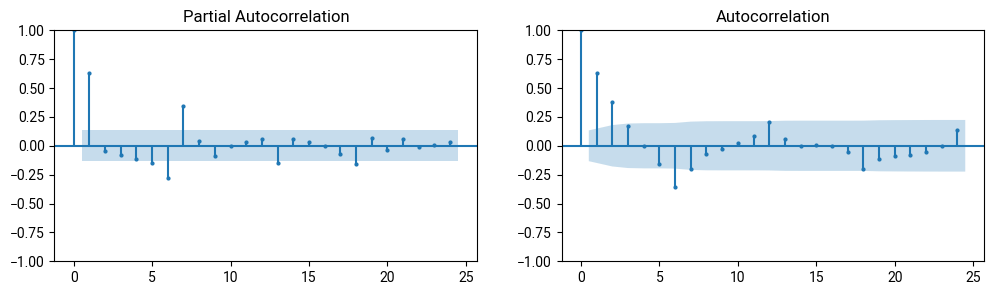

In [10]:
col = "Start-up grant for unemployed"
fig, ax = plt.subplots(1,2, figsize=(12, 3))

plot_pacf(data[col].diff().dropna(), lags=24, ax=ax[0], markersize=2)
plot_acf(data[col].diff().dropna(), lags=24, ax=ax[1], markersize=2)

plt.show()


The PACF plot shows autocorrelation at lages 1,6, and 7. Therefore they are included in the linear model. Further, two constants are added for dates 2020-05-01, 2021-12-01, where they have value 0 prior to the date, and 1 thereafter. 

These two dates were derived from the data itself, eventhough COVID restrictions were lifted two months after. 

In [11]:
col = "Start-up grant for unemployed"
model_df = data.copy()
model_df.loc[:,"COVID start"] = (model_df.index > "2020-05-01").astype(int)
model_df.loc[:,"COVID end"] = (model_df.index > "2021-09-01").astype(int)
model_df["diff"] = model_df[col].diff()
model_df = model_df.dropna()

model = ARIMA(model_df["diff"], exog=model_df[["COVID start", "COVID end"]], order=((1,6,7),0,0)).fit()

print(model.summary())

                                 SARIMAX Results                                  
Dep. Variable:                       diff   No. Observations:                  216
Model:             ARIMA([1, 6, 7], 0, 0)   Log Likelihood               -1125.715
Date:                    Sun, 03 Mar 2024   AIC                           2265.430
Time:                            20:26:05   BIC                           2289.057
Sample:                        02-28-2006   HQIC                          2274.976
                             - 01-31-2024                                         
Covariance Type:                      opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.4281      7.376     -0.465      0.642     -17.885      11.029
COVID start    68.1454     19.831      3.436      0.001      29.278     107.013
COVID end     -5

The regression results shows a clear significance for both COVID start and COVID end. The residuals do not show any autoregressive behaviour, and therefore, the model is reliable. 

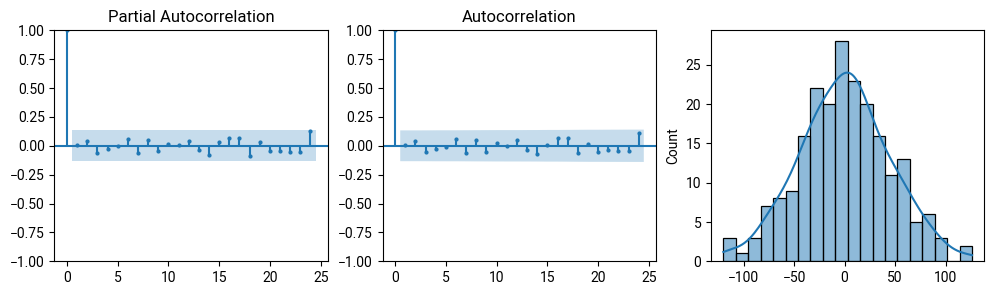

In [12]:
fig, ax = plt.subplots(1,3, figsize=(12, 3))

plot_pacf(model.resid, lags=24, ax=ax[0], markersize=2)
plot_acf(model.resid, lags=24, ax=ax[1], markersize=2)
sns.histplot(model.resid, kde=True, ax=ax[2], bins=20)

plt.show()

# Start-up grant for employed (count)

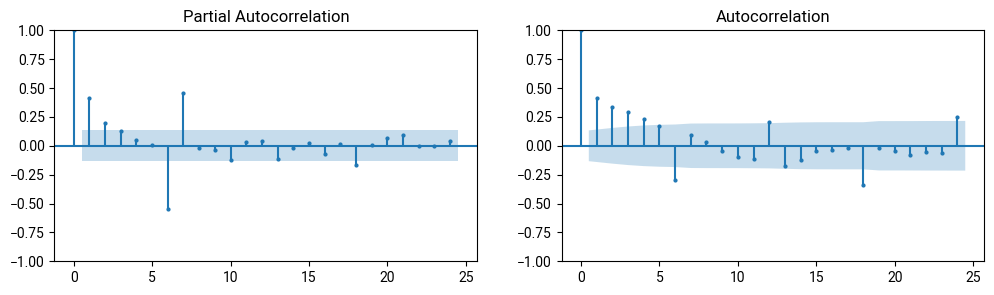

In [13]:
col = "Start-up grant for non-unemployed"
fig, ax = plt.subplots(1,2, figsize=(12, 3))

plot_pacf(data[col].diff().dropna(), lags=24, ax=ax[0], markersize=2)
plot_acf(data[col].diff().dropna(), lags=24, ax=ax[1], markersize=2)

plt.show()


In [14]:
col = "Start-up grant for non-unemployed"
model_df = data.copy()
model_df.loc[:,"COVID start"] = (model_df.index > "2020-05-01").astype(int)
model_df.loc[:,"COVID end"] = (model_df.index > "2021-09-01").astype(int)
model_df["diff"] = model_df[col].diff()
model_df = model_df.dropna()

model = ARIMA(model_df["diff"], exog=model_df[["COVID start", "COVID end"]], order=((1,2,6,7),0,[2])).fit()

print(model.summary())

                                    SARIMAX Results                                    
Dep. Variable:                            diff   No. Observations:                  216
Model:             ARIMA([1, 2, 6, 7], 0, [2])   Log Likelihood               -1171.633
Date:                         Sun, 03 Mar 2024   AIC                           2361.265
Time:                                 20:26:06   BIC                           2391.643
Sample:                             02-28-2006   HQIC                          2373.538
                                  - 01-31-2024                                         
Covariance Type:                           opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5633     10.912      0.143      0.886     -19.824      22.950
COVID start    95.2048     31.568      3.016      0.003 

The result of ARMA model for the non-employed series again, affirms the changes in the levels of application attempts by population. 

The ACF and PACF plots of model residuals do not show any autoregressive behaviour. Therefore the model is fitting properly.

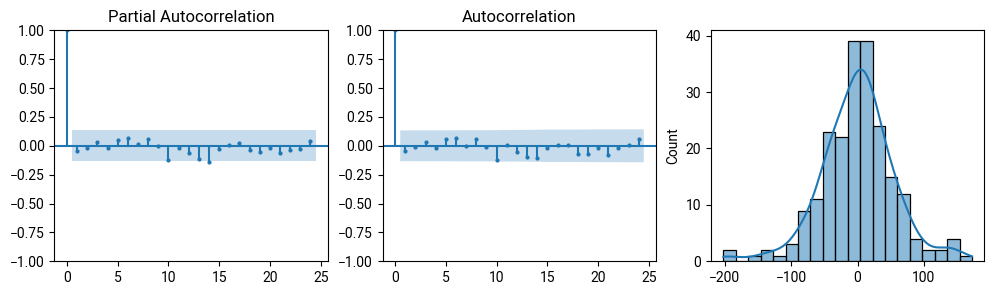

In [15]:
fig, ax = plt.subplots(1,3, figsize=(12, 3))

plot_pacf(model.resid, lags=24, ax=ax[0], markersize=2)
plot_acf(model.resid, lags=24, ax=ax[1], markersize=2)
sns.histplot(model.resid, kde=True, ax=ax[2], bins=20)

plt.show()